In [1]:
import autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K

import numpy as np
import random
import os

import import_ipynb

from utils import mask_operations, df_operations, synthesis_frame, df_operations_wo_alpha
from params import model_params
from dataloader import read_tfrecod_data
from bandERB import ERBBand, ERB_pro_matrix

import librosa
from soundfile import write
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from bandERB.ipynb
importing Jupyter notebook from params.ipynb
importing Jupyter notebook from loss.ipynb
importing Jupyter notebook from dataloader.ipynb


In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  

In [4]:
p = model_params('config.ini')

In [5]:
def band_unit_norm(x, s, alpha=0.99):
    s = np.linalg.norm(x) * (1-alpha) + s * alpha
    x = x / (np.sqrt(s)+1e-12)
    return x, s
def band_mean_norm_erb(x, s, alpha=0.99):
    s = x * (1-alpha) + s * alpha
    x = (x-s) / 40
    return x, s

def erb_norm(x, mean_init=[-60.0,-90.0]):
    # x : [T,F,C]
    # state: [F,C]
    x = np.reshape(x,(x.shape[0],x.shape[1],1))
    shape = x.shape
    state = np.linspace(mean_init[0],mean_init[1],shape[-2]) # [F,]
    state *= 0
    state = np.reshape(state, (1, shape[-2]))
    state = np.tile(state, (1, shape[-1])) # [C,F]
    
    x_i_list = []
    state_list = []
    
    for i in range(shape[-1]):
        x_i = np.split(x, shape[-1], axis=-1) 
        state_i = np.split(state, shape[-1], axis=-1)
        
        x_ij_list = []
        state_tmp = state_i[i]
        for j in range(shape[-3]):
            x_ij = np.split(x_i[i], shape[0], axis=0) 
            x_tmp, state_tmp = band_mean_norm_erb(np.squeeze(x_ij[j],-1), state_tmp)
            x_ij_list.append(x_tmp)
        
        x_i_list.append(np.stack(x_ij_list,1))
        state_list.append(state_tmp)
    x = np.squeeze(np.stack(x_i_list,-1),0)
    return x

def unit_norm(x, unit_init=[0.001, 0.0001]):
    # x : [T,F,C]
    # state: [F,C]
    x = np.reshape(x,(x.shape[0],x.shape[1],1))
    shape = x.shape
    state = np.linspace(unit_init[0],unit_init[1],shape[-2]) # [F,]
    state *= 0
    state = np.reshape(state, (1, shape[-2]))
    state = np.tile(state, (1, shape[-1])) # [C,F]
    
    x_i_list = []
    state_list = []
    
    for i in range(shape[-1]):
        x_i = np.split(x, shape[-1], axis=-1) 
        state_i = np.split(state, shape[-1], axis=-1)
        
        x_ij_list = []
        state_tmp = state_i[i]
        for j in range(shape[-3]):
            x_ij = np.split(x_i[i], shape[0], axis=0) 
            x_tmp, state_tmp = band_unit_norm(np.squeeze(x_ij[j],-1), state_tmp)
            x_ij_list.append(x_tmp)
        
        x_i_list.append(np.stack(x_ij_list,1))
        state_list.append(state_tmp)
    
    x = np.squeeze(np.stack(x_i_list,-1))
#     print('done spec')
    return x

In [6]:
# import tensorflow as tf
def vorbis_window(FRAME_SIZE, transpose=True):
    FRAME_SIZE = FRAME_SIZE//2
    win = np.zeros((FRAME_SIZE,))
    for i in range(FRAME_SIZE):
        win[i] = np.sin(.5*np.pi*np.sin(.5*np.pi*(i+.5)/FRAME_SIZE) * np.sin(.5*np.pi*(i+.5)/FRAME_SIZE))

    win = np.concatenate((win,np.flip(win)),0)
    if transpose: win = win.T
    return win

def analysis_frame(x, nfft=p.fft_size, hop=p.hop_size, normalize=False):
    length = len(x)
    n_frames = length // hop
    out = np.empty((n_frames, p.fft_size//2+1),dtype=complex)
    if not length % hop == 0:
        x = np.pad(x,(0, nfft - length%hop))
    for frame_idx in range(0, n_frames * hop, hop):
        frame = x[frame_idx : frame_idx + nfft]
        if len(frame)<nfft: frame = np.pad(frame,(0,nfft-len(frame)))
        win = vorbis_window(nfft)
        frame = frame.reshape(win.shape)
        frame_win = np.multiply(frame, win)
        x_fft = np.fft.rfft(frame_win, n=p.fft_size) 
        if normalize: x_fft *= (p.fft_size ** -0.5)
        out[frame_idx//hop,:] = x_fft
    return out 

def synthesis_frame(x, nfft=p.fft_size, hop=p.hop_size, windowing=False, normalize=False):
    n_frames, _ = x.shape
    length = (n_frames+1)*hop
    out = np.zeros((length,))

    win = vorbis_window(nfft, transpose=False)
    if normalize: x /= (p.fft_size ** -0.5)
    for frame_idx in range(0, n_frames * hop, hop):
        frame = np.fft.irfft(x[frame_idx//hop] , n=p.fft_size)
        
        if windowing:
            frame = frame.reshape(win.shape)
            out[frame_idx : frame_idx + nfft] += np.multiply(frame, win)
        else:
            out[frame_idx : frame_idx + nfft] += frame
    return out

In [7]:
def as_complex(x):
    if x.dtype == np.complex64 or x.dtype == np.complex128:
        return x
    else:
        return np.complex(x[...,-2], x[..., -1])

def as_real(x):
    if x.dtype == np.complex64 or x.dtype == np.complex128:
        return np.concatenate([np.expand_dims(np.real(x),axis=-1), 
                               np.expand_dims(np.imag(x),axis=-1)],axis=-1)
    else: return x

In [8]:
process_path = '/home/myhsueh/DeepFilterNet/wav/proc/'
audiofile = [ 
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_sample3_01.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_sample1_01.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_sample2_01.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_sample6_01.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_sample7_01.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_sample9_01.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_sample11_01.wav',
              
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_testset/ms_realrec_english_usbmicrophone_APPND34J4EDS3_typing_near_fileid_5.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_testset/ms_realrec_english_speaker_A33BAVCUPSMTWJ_Typing_near_fileid_11.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_testset/ms_realrec_english_openspeaker_ASEW6NZHLI41K_typing_far_fileid_9.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_testset/ms_realrec_english_openspeaker_ASEW6NZHLI41K_openingchipspacket_near_fileid_1.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_testset/ms_realrec_english_openspeaker_A338ZXK723N9UH_dogbarking_near_fileid_si2192.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_testset/ms_realrec_english_openspeaker_A338ZXK723N9UH_babycrying_far_fileid_si1687.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_testset/ms_realrec_english_openspeaker_A338ZXK723N9UH_ArConditioner_near_fileid_si2313.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_testset/ms_realrec_english_laptopmic_A9AP3ED0K8LS8_heavybreathing_near_fileid_6.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/DNS_testset/ms_realrec_emotional_Desktopstandmic_AHLK9SWDJHBBZ_clatternoise_near_crying_fileid_8.wav',
    
              '/home/myhsueh/DeepFilterNet/wav/orig/conference_01.wav',
              '/home/myhsueh/DeepFilterNet/wav/orig/02-V4K-220511_record.wav',
#               '/home/myhsueh/DeepFilterNet/wav/orig/enc_01.wav',
            ]

In [9]:
ERBB = ERBBand(N=p.nb_erb, high_lim=p.sr//2, NFFT=p.fft_size)
ERB_Matrix = ERB_pro_matrix(ERBB, NFFT=p.fft_size, mode=0)
iERB_Matrix = ERB_pro_matrix(ERBB, NFFT=p.fft_size, mode=1)

In [10]:
from tqdm import tqdm
buffer_frame = 1

In [11]:
def squeeze_fuc(x):
    if len(x.shape)==3: 
        if x.shape[1] == 1: x=np.squeeze(x,1)
        else: x=np.squeeze(x,2)
    else:
        pass
    return x

In [12]:
def inference_func_interpreter(interpreter, erb, spec, state0, state10, state11, state20, state21):

    ### state ### 
    state0_input_data = np.array(state0, dtype=np.float32)
    interpreter.set_tensor(interpreter.get_input_details()[6]['index'], state0_input_data)
    state10_input_data = np.array(state10, dtype=np.float32)
    interpreter.set_tensor(interpreter.get_input_details()[2]['index'], state10_input_data)
    state11_input_data = np.array(state11, dtype=np.float32)
    interpreter.set_tensor(interpreter.get_input_details()[1]['index'], state11_input_data)
    state20_input_data = np.array(state20, dtype=np.float32)
    interpreter.set_tensor(interpreter.get_input_details()[4]['index'], state20_input_data)
    state21_input_data = np.array(state21, dtype=np.float32)
    interpreter.set_tensor(interpreter.get_input_details()[3]['index'], state21_input_data)
    ### other
    erb_input_data = np.array(erb, dtype=np.float32)
    interpreter.set_tensor(interpreter.get_input_details()[5]['index'], erb_input_data)
    spec_input_data = np.array(spec, dtype=np.float32)
    interpreter.set_tensor(interpreter.get_input_details()[0]['index'], spec_input_data)

    interpreter.invoke()
    
    ### output
#     mask = interpreter.get_tensor(interpreter.get_output_details()[7]['index'])
#     coeff = interpreter.get_tensor(interpreter.get_output_details()[3]['index'])
#     alpha = interpreter.get_tensor(interpreter.get_output_details()[6]['index'])
    
#     state0_output_data = interpreter.get_tensor(interpreter.get_output_details()[2]['index'])
#     state10_output_data = interpreter.get_tensor(interpreter.get_output_details()[5]['index'])
#     state11_output_data = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])
#     state20_output_data = interpreter.get_tensor(interpreter.get_output_details()[1]['index'])
#     state21_output_data = interpreter.get_tensor(interpreter.get_output_details()[4]['index'])
    mask = interpreter.get_tensor(interpreter.get_output_details()[7]['index'])
    coeff = interpreter.get_tensor(interpreter.get_output_details()[5]['index'])
    alpha = interpreter.get_tensor(interpreter.get_output_details()[6]['index'])
    
    state0_output_data = interpreter.get_tensor(interpreter.get_output_details()[4]['index'])
    state10_output_data = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])
    state11_output_data = interpreter.get_tensor(interpreter.get_output_details()[3]['index'])
    state20_output_data = interpreter.get_tensor(interpreter.get_output_details()[1]['index'])
    state21_output_data = interpreter.get_tensor(interpreter.get_output_details()[2]['index'])
    
    
    return mask, alpha, coeff, state0_output_data, state10_output_data, \
            state11_output_data, state20_output_data, state21_output_data

In [13]:
def inference_func(erb, spec, state0, state10, state11, state20, state21, \
                   interpreter):
    mask, alpha, coeff, state0, state10, state11, state20, state21 \
    = inference_func_interpreter(interpreter, erb, spec, state0, state10, state11, state20, state21)

    return mask, alpha, coeff, state0, state10, state11, state20, state21

In [14]:
def process(audiofile, interpreter, 
            process_path='/home/myhsueh/DeepFilterNet/wav/proc/dfn2_lite/'):
    y, sr = librosa.load(audiofile, sr=None)
    
    new_filename = os.path.basename(audiofile)
    new_filename = new_filename.replace('.wav','_lite_dfn'+str(buffer_frame)+'.wav')

    Y = analysis_frame(y, normalize=True)
    
    state0, state10, state11, state20, state21 = np.zeros((1,256), dtype=np.float32), \
                                                 np.zeros((1,256), dtype=np.float32), \
                                                 np.zeros((1,256), dtype=np.float32), \
                                                 np.zeros((1,256), dtype=np.float32), \
                                                 np.zeros((1,256), dtype=np.float32)
    progress = tqdm(total=Y.shape[0])
    
    Y_erb = (np.real(Y)**2 + np.imag(Y)**2) @ ERB_Matrix
    Y_erb_norm = erb_norm(np.sqrt(Y_erb))
    Y_spec_norm = as_real(unit_norm(Y[:,:p.nb_df]))
                            
    buffer = np.zeros((buffer_frame,p.fft_size//2+1), dtype=complex)
    buffer_erb = np.zeros((buffer_frame+2,32,1), dtype=np.float32)
    buffer_spec = np.zeros((buffer_frame+2,96,2), dtype=np.float32)
    Z = np.zeros_like(Y, dtype=complex)
    mask_recoed = np.zeros_like(Y, dtype=float)
    
    for i in range(Y.shape[0]-1):
        buffer = np.roll(buffer, -1, axis=0)
        buffer[-1] = Y[i]
        if buffer_frame==1:
            buffer[0] = Y[i]
        
        buffer_erb = np.roll(buffer_erb, -1, axis=0)
        buffer_erb[-1] = Y_erb_norm[i]
        
        buffer_spec = np.roll(buffer_spec, -1, axis=0)
        buffer_spec[-1] = Y_spec_norm[i]

        buffer_feature = [np.expand_dims(buffer_erb,0), np.expand_dims(buffer_spec,0)]
        
        state0 = squeeze_fuc(state0)
        state10 = squeeze_fuc(state10)
        state11 = squeeze_fuc(state11)
        state20 = squeeze_fuc(state20)
        state21 = squeeze_fuc(state21)
        
        mask_out, df_alpha, df_coeff, \
        state0, state10, state11, state20, state21 = inference_func(buffer_feature[0], 
                                                                    buffer_feature[1], 
                                                                    state0, 
                                                                    state10, state11, 
                                                                    state20, state21,
                                                                    interpreter)

        buffer_real = np.concatenate((np.expand_dims(np.real(buffer),-1),np.expand_dims(np.imag(buffer),-1)),axis=-1)
        buffer_spec_proc, mask = mask_operations(buffer_real, mask_out, training=True, return_mask=True) # mask gain

        enhanced = df_operations(buffer_spec_proc, df_coeff, df_alpha) # deep filter
    
        enhanced = np.squeeze(enhanced)
        enhanced_complex = np.squeeze(enhanced[..., 0]+1j*enhanced[..., 1])
        
        if buffer_frame==1:
            Z[i,:] = enhanced_complex
        else:
            Z[i,:] = enhanced_complex[-1]
        mask_recoed[i,:] = np.reshape(mask,(481,)).astype(np.float32)
            
        progress.update(1)
    progress.close()     
    
    z = synthesis_frame(Z, windowing=True, normalize=True)

    if not os.path.exists(process_path): os.makedirs(process_path)
    y = np.reshape(y,(y.shape[0],1))
    z = np.reshape(z,(z.shape[0],1))
    
    if y.shape[0]>z.shape[0]:
        z = np.concatenate((np.zeros((y.shape[0]-z.shape[0],1)),z),axis=0)
    if y.shape[0]<z.shape[0]:
        y = np.concatenate((np.zeros((z.shape[0]-y.shape[0],1)),y),axis=0)
        
    write(os.path.join(process_path,new_filename), np.concatenate((y,z),axis=1), 48000)
    
    plt.figure(figsize=(10,5))
    plt.plot(y, color = 'b')
    plt.plot(z, color = 'r')
    plt.legend(['unproc','proc'])
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.imshow(np.fliplr(mask_recoed).T, vmin=0, vmax=1)
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.imshow(20*np.log10(np.abs(np.fliplr(Z).T)+1e-12))
    plt.show()
    
    return Y.shape[0]

In [15]:
interpreter = tf.lite.Interpreter('/home/myhsueh/DeepFilterNet/Keras_DeepFilterNet2/quantized_INT8_wholemodel.tflite')
for information in interpreter.get_input_details():
    print(information)
print('=============================================================')
for information in interpreter.get_output_details():
    print(information)

{'name': 'serving_default_spec_input:0', 'index': 909, 'shape': array([ 1,  3, 96,  2], dtype=int32), 'shape_signature': array([ 1,  3, 96,  2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'serving_default_state11:0', 'index': 910, 'shape': array([  1, 256], dtype=int32), 'shape_signature': array([  1, 256], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'serving_default_state10:0', 'index': 911, 'shape': array([  1, 256], dtype=int32), 'shape_signature': array([  1, 256], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float

100%|█████████▉| 1471/1472 [00:11<00:00, 133.55it/s]


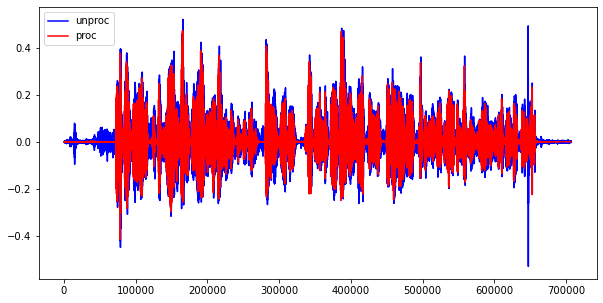

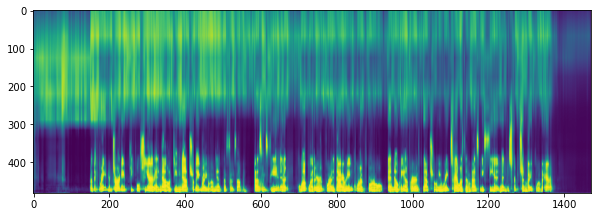

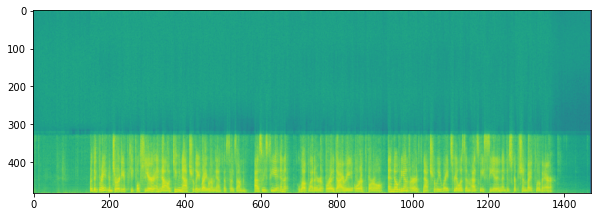

0.009424023654149927


100%|█████████▉| 1207/1208 [00:08<00:00, 147.48it/s]


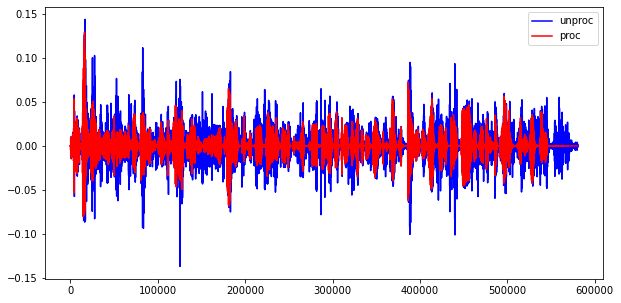

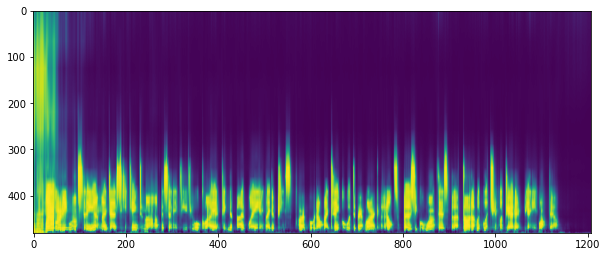

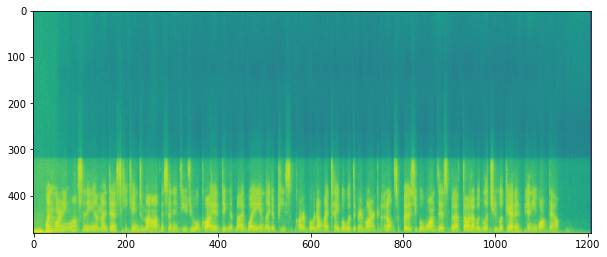

0.008327567024736216


100%|█████████▉| 999/1000 [00:06<00:00, 155.65it/s]


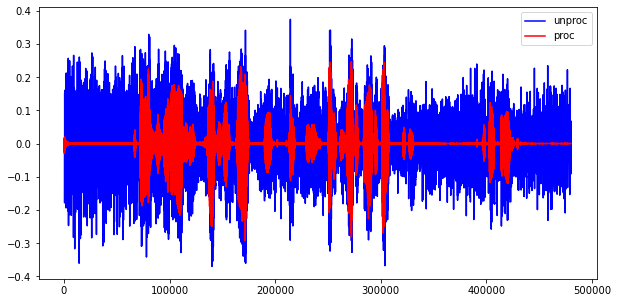

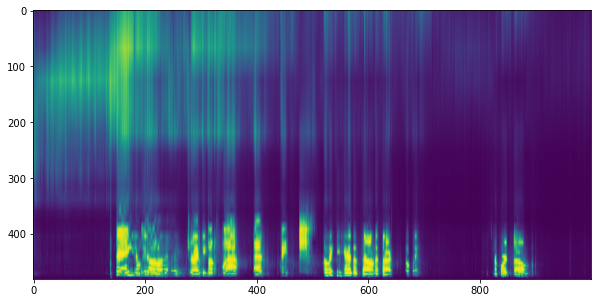

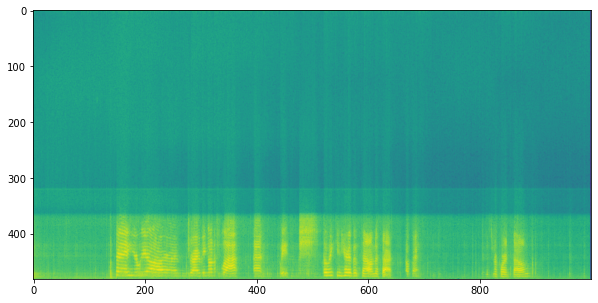

0.00814018702507019


100%|█████████▉| 1161/1162 [00:07<00:00, 153.21it/s]


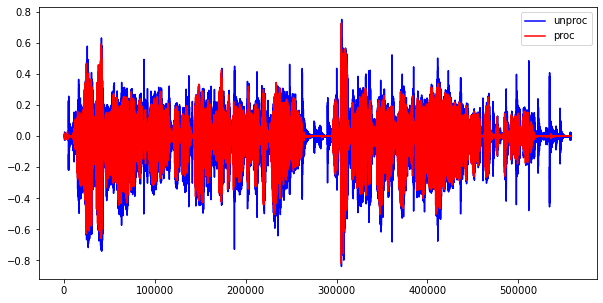

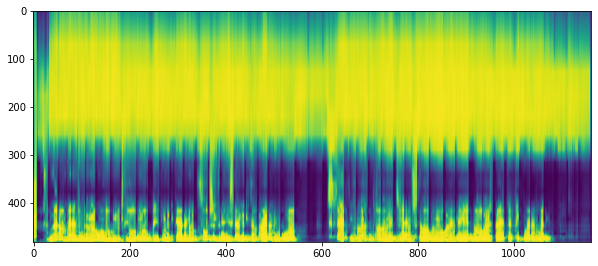

0.008444828749113361


100%|█████████▉| 1623/1624 [00:12<00:00, 131.03it/s]


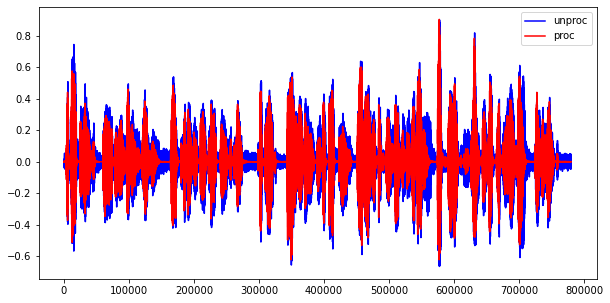

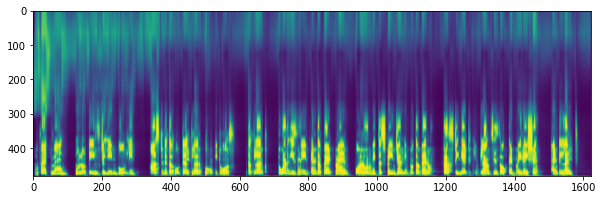

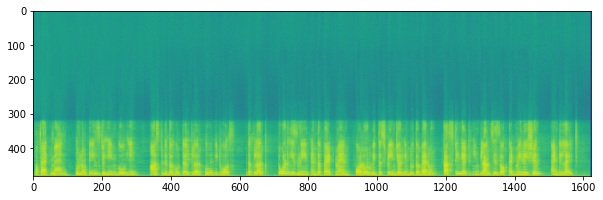

0.009388829980577742


100%|█████████▉| 999/1000 [00:06<00:00, 161.70it/s]


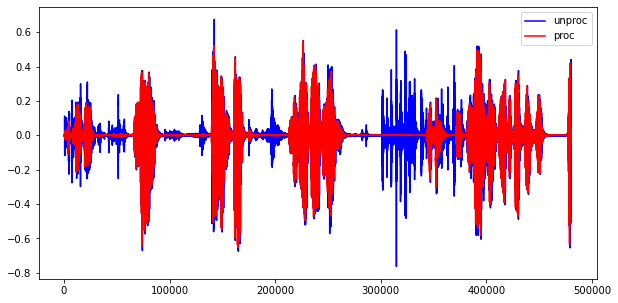

0.007996217250823974


100%|█████████▉| 999/1000 [00:06<00:00, 157.32it/s]


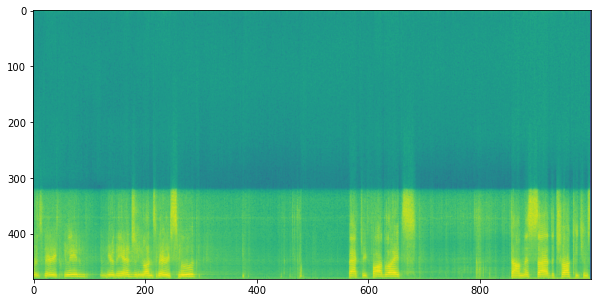

0.008413425922393799


100%|█████████▉| 1686/1687 [00:13<00:00, 128.22it/s]


0.009406208638686998


100%|█████████▉| 1367/1368 [00:09<00:00, 136.81it/s]


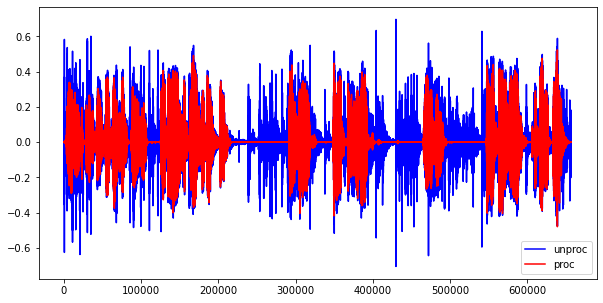

0.009804768171923899


100%|█████████▉| 1698/1699 [00:13<00:00, 127.44it/s]


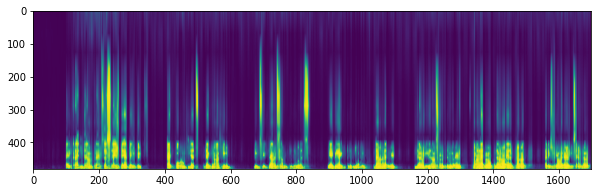

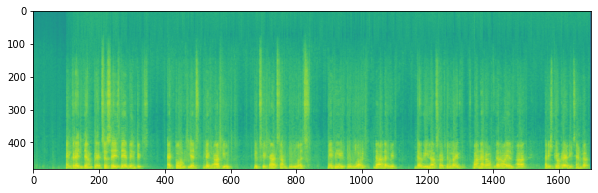

0.009473591849970917


100%|█████████▉| 1243/1244 [00:09<00:00, 135.18it/s]


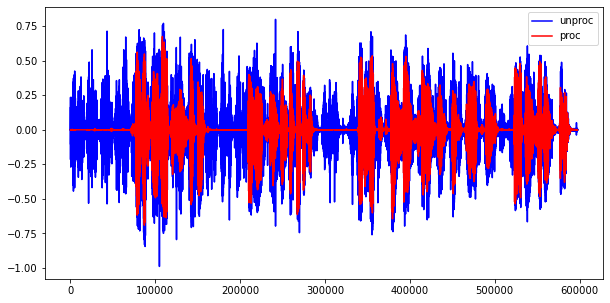

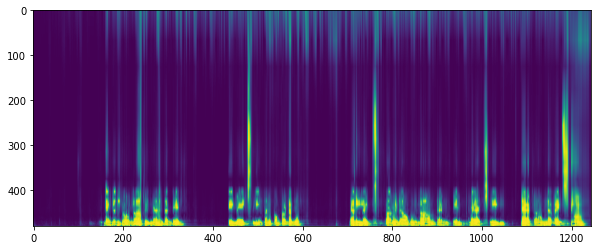

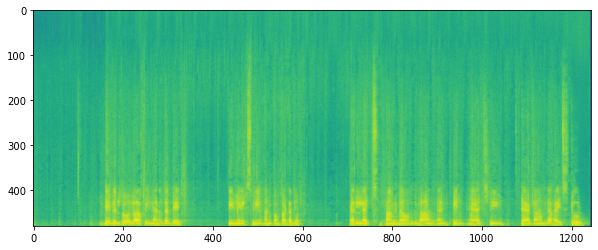

0.009097877039403394


100%|█████████▉| 1181/1182 [00:08<00:00, 145.42it/s]


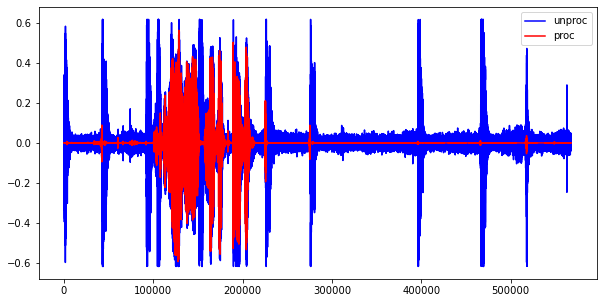

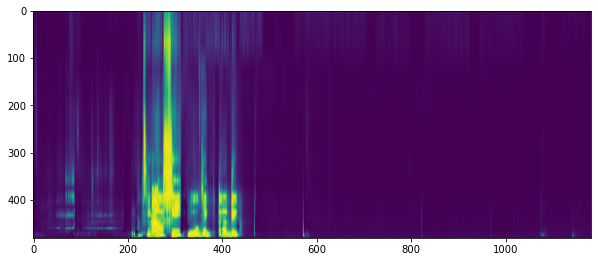

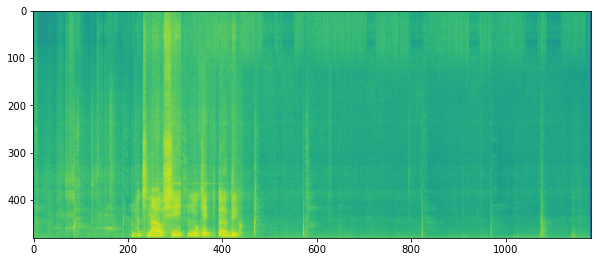

0.008493874883893783


100%|█████████▉| 1274/1275 [00:09<00:00, 140.83it/s]


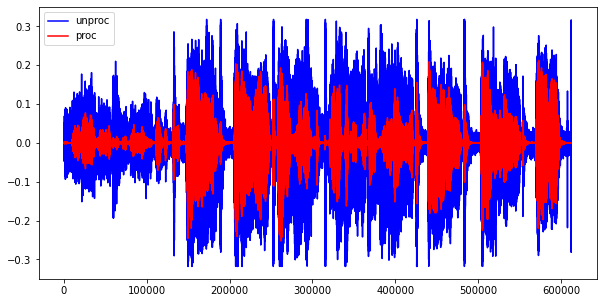

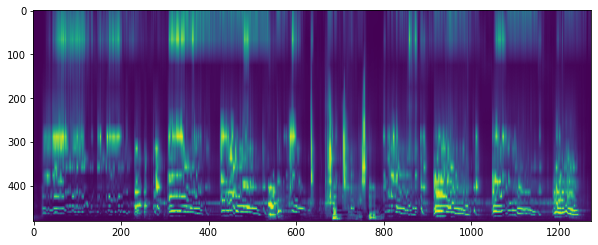

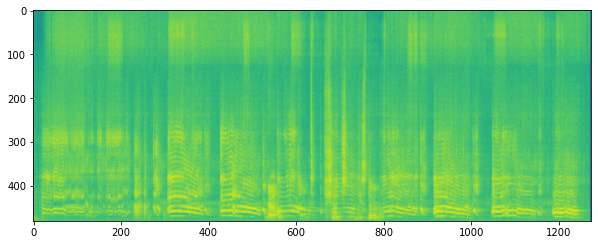

0.00922659855262906


100%|█████████▉| 1294/1295 [00:09<00:00, 139.39it/s]


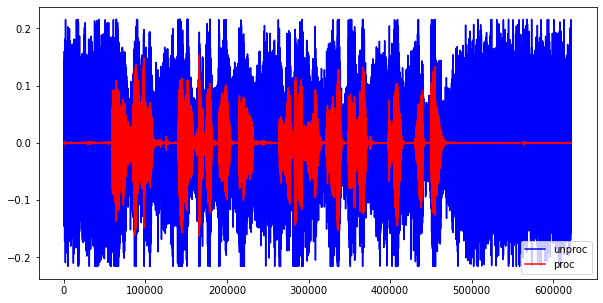

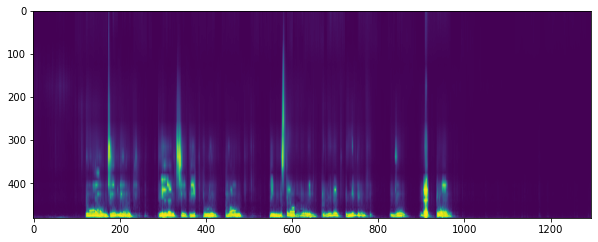

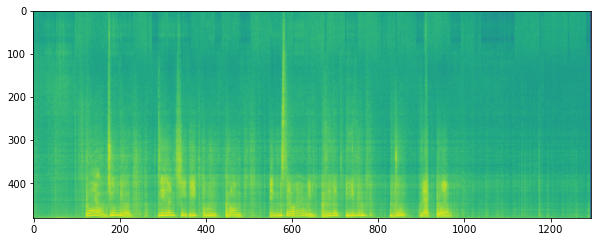

0.011006449916648129


100%|█████████▉| 1366/1367 [00:10<00:00, 133.96it/s]


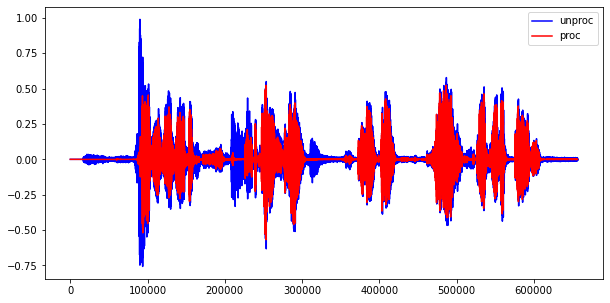

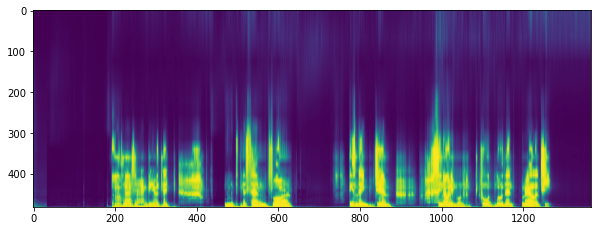

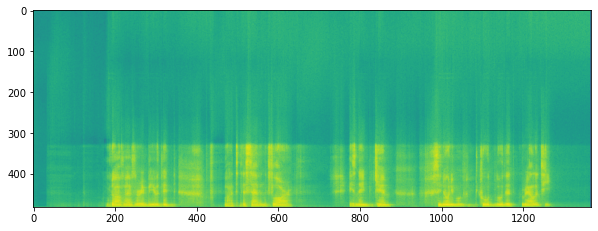

0.009200277691264178


100%|█████████▉| 1566/1567 [00:12<00:00, 127.02it/s]


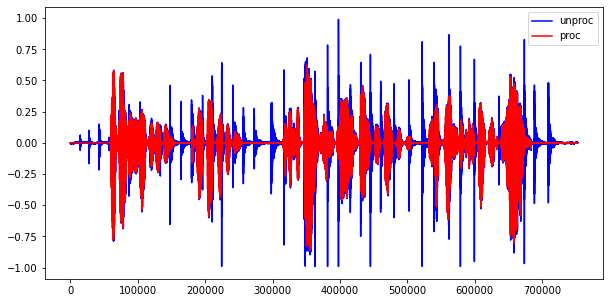

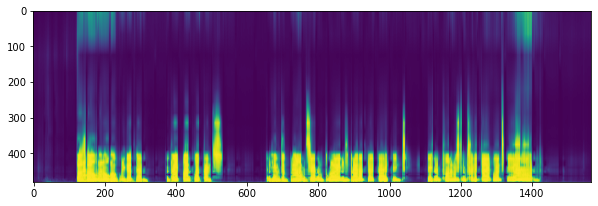

0.009586056403164355


100%|█████████▉| 3412/3413 [00:40<00:00, 83.35it/s] 


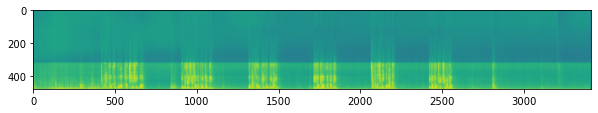

0.013894355230725408


100%|█████████▉| 14202/14203 [08:48<00:00, 26.88it/s]  


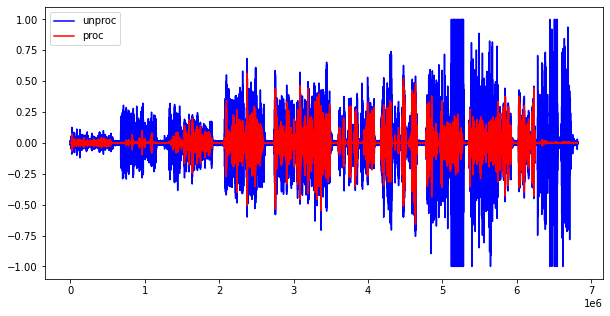

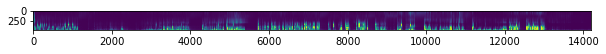

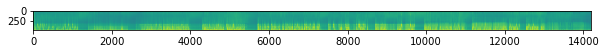

0.039008527408726894


In [16]:
import time
for file in audiofile:
    interpreter = tf.lite.Interpreter('/home/myhsueh/DeepFilterNet/Keras_DeepFilterNet2/quantized_INT8_wholemodel.tflite')

    interpreter.allocate_tensors()
    
    start = time.time()
    num_frame=process(file,interpreter)
    end = time.time()
    
    print((end-start)/num_frame)
    
    interpreter.reset_all_variables()
    
    del interpreter